In [1]:
# Constants
S3_BUCKET_PATH="s3://ads-datasets/wordle-player"
S3_FLD_CSV="flat"
S3_FLD_PQT="parquet"

FILENAME_GAMETURNS_CSV = "game-turns.csv"
FILENAME_GAMETURNS_PQT = "game-turns.parquet"
FILENAME_VALIDWORDATTEMPTS_CSV = "valid-word-attempts.csv"
FILENAME_VALIDWORDATTEMPTS_PQT = "valid-word-attempts.parquet"

WORD_LENGTH = 5

In [2]:
# Helper dict to locate files in s3
src_raw = {
  S3_FLD_CSV: {
    'folder': S3_FLD_CSV,
    'file': {
      'gameturns': FILENAME_GAMETURNS_CSV,
      'validwordattempts': FILENAME_VALIDWORDATTEMPTS_CSV,
    }
  },
  S3_FLD_PQT: {
    'folder': S3_FLD_PQT,
    'file': {
      'gameturns': FILENAME_GAMETURNS_PQT,
      'validwordattempts': FILENAME_VALIDWORDATTEMPTS_PQT,
    }
  }
}

In [3]:
import awswrangler as wr
import os

# Loads the raw data
def load_raw_data(format=S3_FLD_PQT, filename='gameturns'):
  bucket_path = S3_BUCKET_PATH
  fld_format = src_raw[format]['folder']
  file_name = src_raw[format]['file'][filename]

  path = os.path.join(bucket_path, fld_format, file_name)

  return wr.s3.read_parquet(path=path)

In [4]:
# Inspect game turns data from parquet 
df = load_raw_data(format=S3_FLD_PQT, filename='gameturns')
df.head()

,gameId,turns
0,c7q67hdsi8ns738u2vm0,"[{'guess': 'LEACH', 'isValid': True, 'tryResul..."
1,c7q67klsi8ns738u36dg,"[{'guess': 'ACXNX', 'isValid': False, 'tryResu..."
2,c7q67ktsi8ns738u36vg,"[{'guess': 'ALUZV', 'isValid': False, 'tryResu..."
3,c7q67l5si8ns738u37ag,"[{'guess': 'UBUHK', 'isValid': False, 'tryResu..."
4,c7q67l5si8ns738u37fg,"[{'guess': 'VHERY', 'isValid': False, 'tryResu..."


In [5]:
# Inspect valid word attempt data from parquet 
df = load_raw_data(format=S3_FLD_PQT, filename='validwordattempts')
df.head()

,guess,isValid,gameId
0,LEACH,True,c7q67hdsi8ns738u2vm0
1,BNVUX,False,c7q67hdsi8ns738u2vm0
2,NHBLJ,False,c7q67hdsi8ns738u2vm0
3,JZJKV,False,c7q67hdsi8ns738u2vm0
4,HCPXK,False,c7q67hdsi8ns738u2vm0


In [6]:
import pandas as pd

# Inspect the imbalance of isValid rows
df_label_counts = pd.DataFrame(df['isValid'].value_counts(normalize=True))
df_label_counts

,isValid
False,0.702346
True,0.297654


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

letter_cols = [f'l{n}' for n in range(WORD_LENGTH)]

# Prepare valid words dataset
def prepare_valid_word_data(format=S3_FLD_PQT, filename='validwordattempts', test_size=0.1):
  df = load_raw_data(format=S3_FLD_PQT, filename='validwordattempts')

  # Split each guess word to letters in individual columns
  df = df.join(
    pd.DataFrame(
      [list(w) for w in df['guess']], 
      columns=letter_cols)
    )
  
  # Training-testing split
  y = df['isValid'].astype(int)
  X = df.drop(['isValid'], axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y)

  return X_train, X_test, y_train, y_test


In [8]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import compute_class_weight

# Train a classifier
def train_classifier(X_train, y_train, clf=LogisticRegression()):
  global ohe 

  # One-hot encode the letters
  ohe = OneHotEncoder(handle_unknown='error')
  X_train_ohe = ohe.fit_transform(X_train[letter_cols])

  # Fit the training data
  clf.fit(X_train_ohe, y_train.to_numpy())
  
  return clf


# Predict from a trained classifier
def predict_from_classifier(X, clf):
  global ohe
  X_ohe = ohe.transform(X[letter_cols])

  return clf.predict(X_ohe)


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score

# Plot results as a confusion matrix
def plot_confusion_matrix(name, prediction, y_test):
  accuracy = accuracy_score(y_true=y_test, y_pred=prediction)
  f1 = f1_score(y_true=y_test, y_pred=prediction)
  precision = precision_score(y_true=y_test, y_pred=prediction)
  recall = recall_score(y_true=y_test, y_pred=prediction)

  cf_matrix = confusion_matrix(y_true=y_test, y_pred=prediction)

  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  summary_text = classification_report(y_true=y_test, y_pred=prediction)

  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)

  figsize = plt.rcParams.get('figure.figsize')
  plt.figure(figsize=figsize)
  sns.heatmap(
    cf_matrix/np.sum(cf_matrix), 
    annot=labels,
    fmt='', 
    cmap='Blues')
  plt.xlabel(name + '\n' + summary_text)

  return classification_report(y_true=y_test, y_pred=prediction)

  

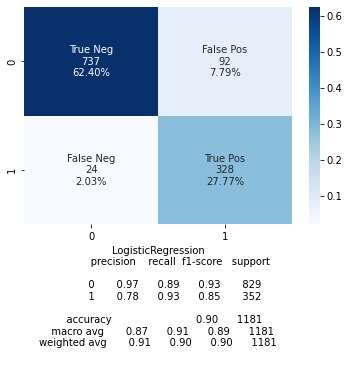

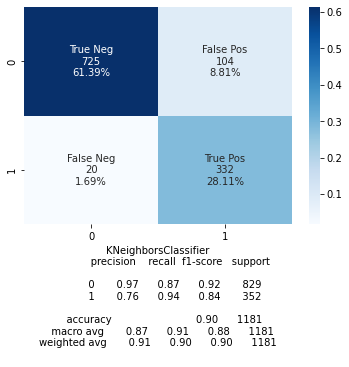

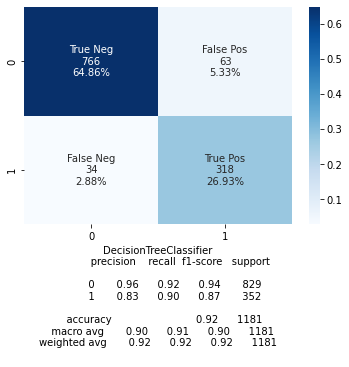

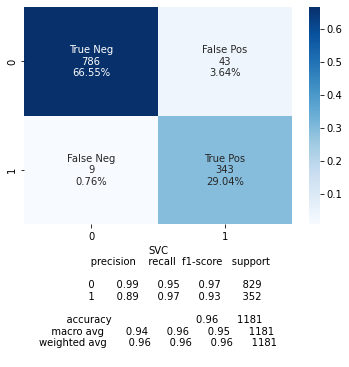

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Try a few different classifiers
clf_dict = {
  'LogisticRegression': LogisticRegression(class_weight='balanced'),
  'KNeighborsClassifier': KNeighborsClassifier(),
  'DecisionTreeClassifier': DecisionTreeClassifier(class_weight='balanced'),
  'SVC': SVC(class_weight='balanced'),
}

# Load and prep the data
X_train, X_test, y_train, y_test = prepare_valid_word_data()

# Train and plot the confusion matrices
for name in clf_dict:
  clf = clf_dict[name]
  model = train_classifier(X_train, y_train, clf)
  prediction = predict_from_classifier(X_test, model)
  plot_confusion_matrix(name, prediction, y_test)


'              precision    recall  f1-score   support\n\n           0       0.98      0.97      0.98       829\n           1       0.94      0.96      0.95       352\n\n    accuracy                           0.97      1181\n   macro avg       0.96      0.97      0.96      1181\nweighted avg       0.97      0.97      0.97      1181\n'

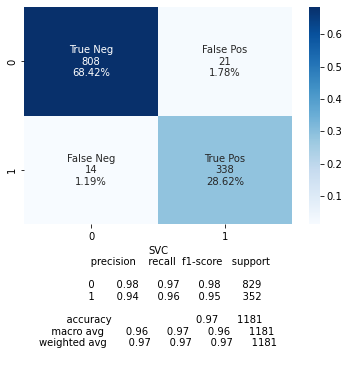

In [11]:
from sklearn.svm import SVC

# Use best performing classifier
clf = SVC(kernel='poly', degree=3, class_weight='balanced')

# Load and prep the data
X_train, X_test, y_train, y_test = prepare_valid_word_data()

# Train and plot the confusion matrices
model = train_classifier(X_train, y_train, clf)
prediction = predict_from_classifier(X_test, model)
plot_confusion_matrix(name, prediction, y_test)


In [12]:
# Inspect the test predictions
df_test_pred = X_test.join(y_test)
df_test_pred['prediction'] = prediction == y_test

# False negatives
df_test_pred_fn = df_test_pred[(df_test_pred['prediction'] == False) & (df_test_pred['isValid'] == 0)]
# False positives
df_test_pred_fp = df_test_pred[(df_test_pred['prediction'] == False) & (df_test_pred['isValid'] == 1)]
# True negatives
df_test_pred_tn = df_test_pred[(df_test_pred['prediction'] == True) & (df_test_pred['isValid'] == 0)]
# True positives
df_test_pred_tp = df_test_pred[(df_test_pred['prediction'] == True) & (df_test_pred['isValid'] == 1)]


In [13]:
df_test_pred_fp

,guess,gameId,l0,l1,l2,l3,l4,isValid,prediction
2848,YUKON,c7q6tdgqcq3c73e1fia0,Y,U,K,O,N,1,False
10679,ALKYL,c7q6tm0qcq3c73e1fsm0,A,L,K,Y,L,1,False
2778,YIELD,c7q6tdgqcq3c73e1fi70,Y,I,E,L,D,1,False
3039,UPSET,c7q6tdoqcq3c73e1fii0,U,P,S,E,T,1,False
4631,EBONY,c7q6tfgqcq3c73e1fkmg,E,B,O,N,Y,1,False
8030,OPIUM,c7q6tj0qcq3c73e1fp60,O,P,I,U,M,1,False
6128,QUIRK,c7q6th0qcq3c73e1fmm0,Q,U,I,R,K,1,False
7138,CLERK,c7q6ti0qcq3c73e1fo0g,C,L,E,R,K,1,False
5420,OMEGA,c7q6tg8qcq3c73e1flo0,O,M,E,G,A,1,False
5584,ABUZZ,c7q6tggqcq3c73e1flv0,A,B,U,Z,Z,1,False


In [14]:
df_test_pred_fn

,guess,gameId,l0,l1,l2,l3,l4,isValid,prediction
5962,ROSTY,c7q6tgoqcq3c73e1fmf0,R,O,S,T,Y,0,False
10654,CAGLT,c7q6tm0qcq3c73e1fsl0,C,A,G,L,T,0,False
7322,PILRS,c7q6ti8qcq3c73e1fo8g,P,I,L,R,S,0,False
6903,COGEX,c7q6thoqcq3c73e1fnmg,C,O,G,E,X,0,False
8564,EOVNS,c7q6tjoqcq3c73e1fpsg,E,O,V,N,S,0,False
5012,ANJOL,c7q6tfoqcq3c73e1fl70,A,N,J,O,L,0,False
3432,FAUET,c7q6te0qcq3c73e1fj30,F,A,U,E,T,0,False
1302,DLOAY,c7q6tboqcq3c73e1fg90,D,L,O,A,Y,0,False
449,COFDY,c7q6f1tsi8ns738u3mpg,C,O,F,D,Y,0,False
5281,DEBRY,c7q6tg8qcq3c73e1fli0,D,E,B,R,Y,0,False


In [15]:
df_test_pred_tp

,guess,gameId,l0,l1,l2,l3,l4,isValid,prediction
9744,ALOOF,c7q6tl0qcq3c73e1freg,A,L,O,O,F,1,True
6298,THIGH,c7q6th8qcq3c73e1fmt0,T,H,I,G,H,1,True
4855,ELBOW,c7q6tfoqcq3c73e1fl00,E,L,B,O,W,1,True
3134,ATONE,c7q6tdoqcq3c73e1fim0,A,T,O,N,E,1,True
6428,WIPER,c7q6th8qcq3c73e1fn2g,W,I,P,E,R,1,True
...,...,...,...,...,...,...,...,...,...
6025,GLOSS,c7q6th0qcq3c73e1fmhg,G,L,O,S,S,1,True
4531,RUSTS,c7q6tf8qcq3c73e1fki0,R,U,S,T,S,1,True
9549,PLANK,c7q6tkoqcq3c73e1fr6g,P,L,A,N,K,1,True
760,SWISH,c7q6f25si8ns738u3n7g,S,W,I,S,H,1,True


In [16]:
df_test_pred_tn

,guess,gameId,l0,l1,l2,l3,l4,isValid,prediction
7897,VBXOE,c7q6tj0qcq3c73e1fp0g,V,B,X,O,E,0,True
14,RPNGF,c7q67klsi8ns738u36dg,R,P,N,G,F,0,True
6732,GDUNA,c7q6thoqcq3c73e1fnfg,G,D,U,N,A,0,True
2710,RNTJA,c7q6td8qcq3c73e1fi40,R,N,T,J,A,0,True
10500,QDQHP,c7q6tloqcq3c73e1fseg,Q,D,Q,H,P,0,True
...,...,...,...,...,...,...,...,...,...
8841,DIJKF,c7q6tk0qcq3c73e1fq8g,D,I,J,K,F,0,True
11317,JQFZO,c7q6tmgqcq3c73e1fthg,J,Q,F,Z,O,0,True
11756,DOJYP,c7q6tn0qcq3c73e1fu40,D,O,J,Y,P,0,True
10566,YLRJQ,c7q6tloqcq3c73e1fsh0,Y,L,R,J,Q,0,True
